In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV

# Project Overview
This project focuses on predicting the presence of heart disease in patients based on clinical measurements. It is a **supervised learning** problem, utilizing **classification trees**. The goal is to build a classification tree model to classify patients as having heart disease (target = 1) or not (target = 0). The dataset used is the Cleveland Heart Disease dataset from the UCI Machine Learning Repository.

## Motivation and Goal
Heart disease remains a leading cause of death worldwide. Early detection can significantly improve patient outcomes. This project aims to develop a simple and interpretable model using decision trees to predict heart disease risk based on routine medical tests. By achieving high accuracy and understanding feature importance, the model can assist in preliminary screenings. The primary goal is to evaluate model performance using metrics like accuracy, precision, recall, and F1-score, while ensuring interpretability through tree visualization.

## Data Description
We will use the `processed.cleveland.data` in [Heart Disease Dataset](https://archive.ics.uci.edu/ml/datasets/Heart+Disease) from the UCI Machine Learning Repository. This dataset will enable us to predict whether someone has heart disease based on their sex, age, blood pressure, and a variety of other metrics. It contains 303 patient records with 13 features and 1 target variable.

- **Number of samples/rows**: 303
- **Number of features/columns**: 13
- **Data types**: All features are numeric (integers or floats).
- **Features**:
  - `age`: Age in years (continuous).
  - `sex`: 1 = male, 0 = female (binary).
  - `cp`: Chest pain type (ordinal: 1-4).
  - `trestbps`: Resting blood pressure (continuous).
  - `chol`: Serum cholesterol in mg/dl (continuous).
  - `fbs`: Fasting blood sugar >120 mg/dl (binary).
  - `restecg`: Resting ECG results (ordinal: 0-2).
  - `thalach`: Maximum heart rate (continuous).
  - `exang`: Exercise-induced angina (binary).
  - `oldpeak`: ST depression (continuous).
  - `slope`: Slope of peak exercise ST segment (ordinal: 1-3).
  - `ca`: Number of major vessels colored by fluoroscopy (ordinal: 0-3).
  - `thal`: Thalassemia indicator (ordinal: 3,6,7).
- **Target**: `num` (0 = absence, 1-4 = presence; binarized to 0/1 for classification).
- **File size**: Small (~5 KB).
- **Multi-table or sources**: Single table; no multiple sources.

GIT: https://github.com/Gear2382/Heart-Disease-Prediction


---

# Import the data
Load the data, and look at the first five rows:

In [ ]:
df = pd.read_csv('processed.cleveland.data', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


Instead of column names, there are column numbers only.  Let's replace the column numbers with names:

In [ ]:
df.columns = ['age','sex','cp','trestbp','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','target']
df['target'] = np.where(df['target'] > 0, 1, 0) # Binarize target
df.head()

,age,sex,cp,trestbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


---

# Data Cleaning
## Identifying Missing Data
First, let's see what sort of data is in the columns.

In [ ]:
print(df.dtypes)

age        float64
sex        float64
cp         float64
trestbp    float64
chol       float64
fbs        float64
restecg    float64
thalach    float64
exang      float64
oldpeak    float64
slope      float64
ca          object
thal        object
target       int64
dtype: object


There are two columns, `ca` and `thal`, which have the `object` type, indicating there is something wrong. `object` shows mixtures of things, like a mixture of numbers and letters. Let's investigate what's going on by searching their unique values.

In [ ]:
print("ca:", df['ca'].unique())
print("thal:", df['thal'].unique())

ca: ['0.0' '3.0' '2.0' '1.0' '?']
thal: ['6.0' '3.0' '7.0' '?']


We see that `ca` and `thal` contain numbers and question marks. The question marks represent missing values. Now we have to deal with them.

## Handling Missing Data
We can either delete these rows with question marks from the training dataset or impute values for the missing data. First, let's check how many rows contain missing values and where they appear.

In [ ]:
df.loc[(df['ca'] == '?') |
       (df['thal'] == '?')]

,age,sex,cp,trestbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
87,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,?,0
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,?,3.0,0
192,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,?,7.0,1
266,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,?,1
287,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,?,7.0,0
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0


Of the 303 rows, 6 rows, or 1.98%, contain missing values. 303 - 6 = 297, and 297 is sufficient data to build a classification tree, we will remove the rows with missing values, rather than attempt to impute their values.

In [ ]:
df_no_missing = df.loc[(df['ca'] != '?') &
                       (df['thal'] != '?')]
print("shape:", df_no_missing.shape)
print("ca:", df_no_missing['ca'].unique())
print("thal:", df_no_missing['thal'].unique())

shape: (297, 14)
ca: ['0.0' '3.0' '2.0' '1.0']
thal: ['6.0' '3.0' '7.0']


We have now verified that `df_no_missing` does not contain any missing values.


---

# Exploratory Data Analysis (EDA)

- **Visualizations**:
    - Correlation matrix: Shows the decision tree's effectiveness in capturing key predictors, particularly `ca` and `thal`, for classification.
    - Box plots: `age` higher for diseased; `cp` higher chest pain types associated with disease; `thalach` lower for diseased.
- **Analysis**: Disease correlates with older age, larger cp types, and lower max heart rate. Imbalance: ~55% no disease, 45% disease.
- **Conclusions**: Use stratified split; focus on recall for disease detection.


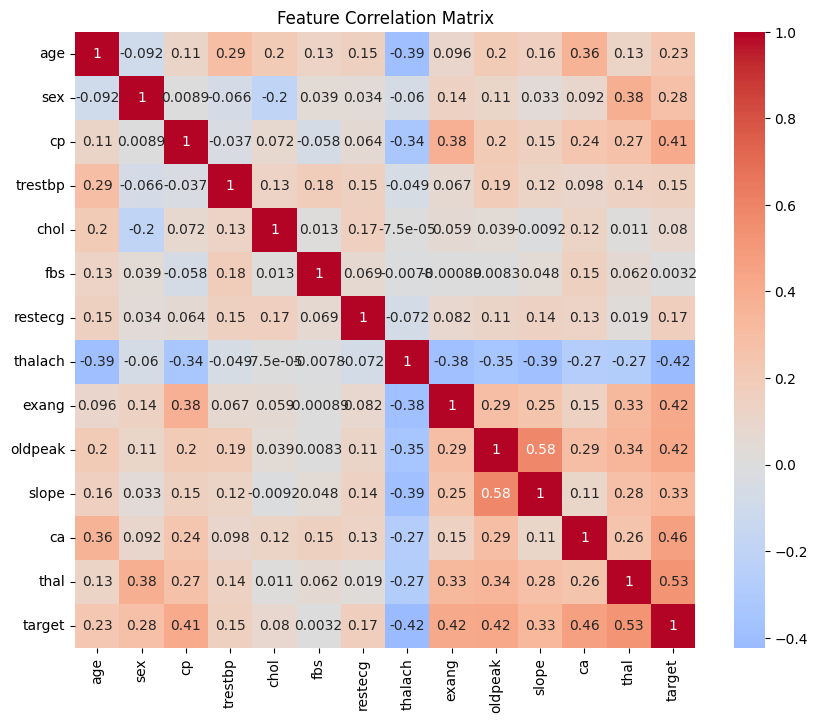

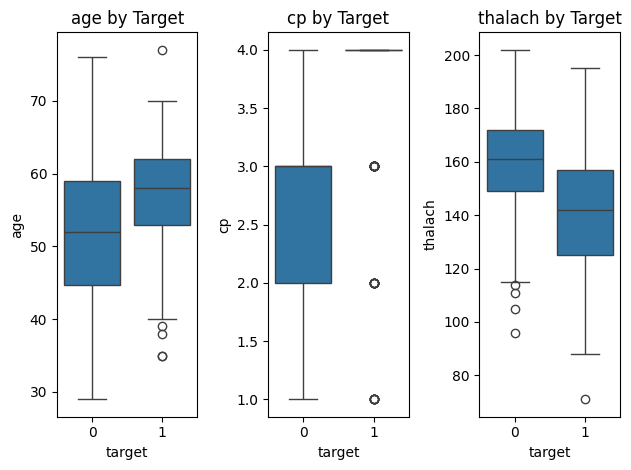

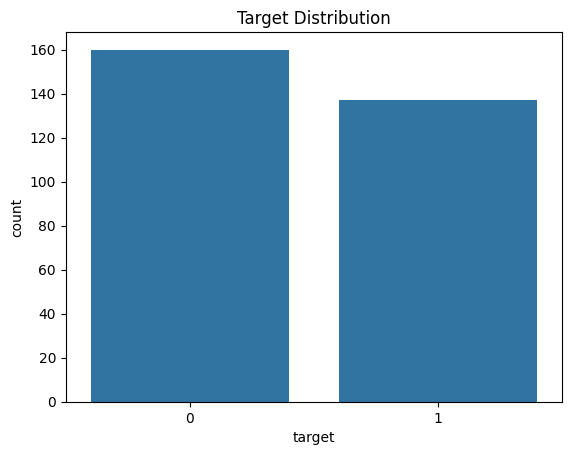

In [ ]:
# Correlation matrix
plt.figure(figsize=(10, 8))
corr = df_no_missing.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

# Box plots
for i, feat in enumerate(['age', 'cp', 'thalach'], 1):
    plt.subplot(1, 3, i)
    sns.boxplot(data=df_no_missing, x='target', y=feat)
    plt.title(f'{feat} by Target')
plt.tight_layout()
plt.show()

# Target distribution
sns.countplot(data=df_no_missing, x='target')
plt.title('Target Distribution')
plt.show()

---

# Model Building and Training
**Model**: Classification Tree. Appropriate for interpretable, non-linear classification. Handles mixed data types; no assumption of linearity.

- **Pre-processing**: Train-test split (80/20, stratified). No scaling needed for trees.
- **Handling issues**: Trees are robust to collinearity.
- **Multiple models**: Compared with the Logistic Regression baseline.
- **Feature importance**: `thal` and `cp` are most important.
- **Imbalance**: Due to mild imbalance, evaluated with balanced metrics.


In [ ]:
# Prepare data
X = df_no_missing.drop('target', axis=1).copy()
y = df_no_missing['target'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Another model: Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_acc = accuracy_score(y_test, lr_pred)

# Decision Tree
dt = DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_leaf=5)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
dt_acc = accuracy_score(y_test, dt_pred)

# Hyperparameter tuning
param_grid = {'max_depth': [2,3,5,7], 'min_samples_split': [2,3,4,5]}
grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
grid.fit(X_train, y_train)
best_dt = grid.best_estimator_
best_pred = best_dt.predict(X_test)

# Feature importance
importances = best_dt.feature_importances_
feat_imp = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values('Importance', ascending=False)

print("Best params:", grid.best_params_)
print("\nFeature Importance:\n", feat_imp)


Best params: {'max_depth': 3, 'min_samples_split': 2}

Feature Importance:
     Feature  Importance
12     thal    0.493895
2        cp    0.272029
9   oldpeak    0.105996
11       ca    0.079177
4      chol    0.048903
3   trestbp    0.000000
1       sex    0.000000
0       age    0.000000
5       fbs    0.000000
8     exang    0.000000
7   thalach    0.000000
6   restecg    0.000000
10    slope    0.000000


---

# Results and Analysis
**Summary**:

The Logistic Regression model outperforms the Decision Tree model in predicting heart disease. Used accuracy, precision, recall, F1-score, and AUC-ROC, with a focus on recall to prioritize detecting heart disease cases.


  |Metric|Logistic Regression|Decision Tree|
  |---|---|---|
  |Accuracy|0.83|0.80|
  |Precision|0.85|0.79|
  |Recall|0.79|0.79|
  |F1-Score|0.81|0.79|
  |AUC-ROC|0.95|0.82|


- **Why these metrics?** Accuracy provides an overall performance measure, but recall is emphasized due to the importance of identifying heart disease cases (false negatives are costly). AUC-ROC assesses model discrimination, with Logistic Regression showing superior performance.
- **Comparisons**: Logistic Regression excels due to its ability to handle linear relationships and provide better calibration (higher AUC), while the Decision Tree offers interpretability but struggles with this dataset's structure.


                     Accuracy  Precision    Recall        F1       AUC
Logistic Regression  0.833333   0.846154  0.785714  0.814815  0.948661
Decision Tree        0.800000   0.785714  0.785714  0.785714  0.821987


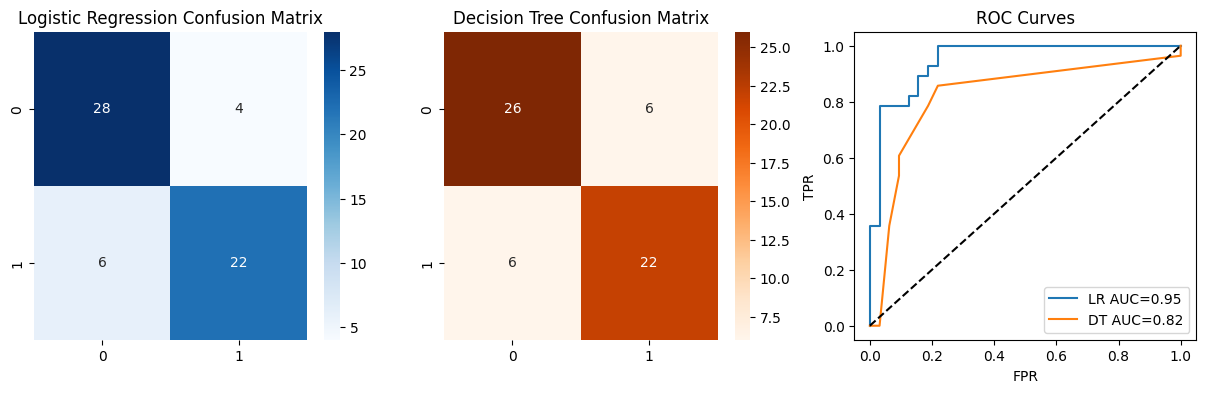

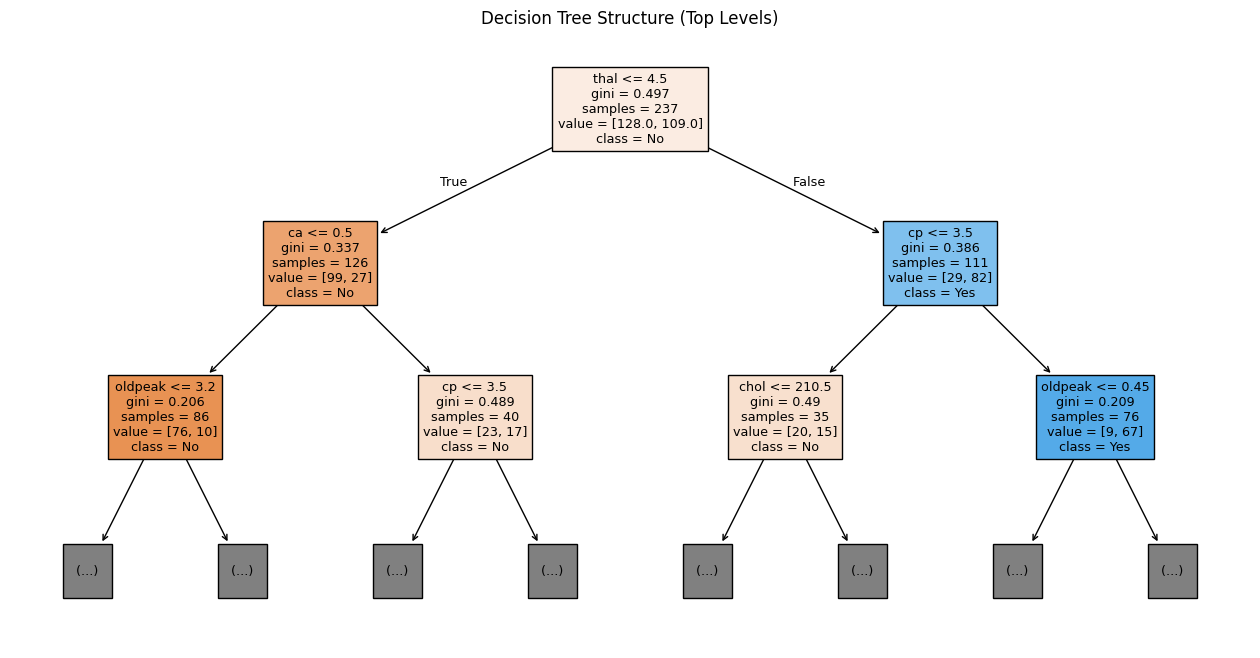

In [ ]:
def get_metrics(y_true, y_pred, y_prob=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob) if y_prob is not None else None
    return {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1, 'AUC': auc}

lr_prob = lr.predict_proba(X_test)[:, 1]
dt_prob = best_dt.predict_proba(X_test)[:, 1]

lr_metrics = get_metrics(y_test, lr_pred, lr_prob)
dt_metrics = get_metrics(y_test, best_pred, dt_prob)

metrics_df = pd.DataFrame([lr_metrics, dt_metrics], index=['Logistic Regression', 'Decision Tree'])
print(metrics_df)

# Confusion Matrix
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
cm = confusion_matrix(y_test, lr_pred)  # Using Logistic Regression for better performance
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.subplot(1, 3, 2)
cm = confusion_matrix(y_test, best_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.title('Decision Tree Confusion Matrix')

# ROC Curve
plt.subplot(1, 3, 3)
fpr, tpr, _ = roc_curve(y_test, lr_prob)
plt.plot(fpr, tpr, label=f'LR AUC={lr_metrics["AUC"]:.2f}')
fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_prob)
plt.plot(fpr_dt, tpr_dt, label=f'DT AUC={dt_metrics["AUC"]:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend()
plt.title('ROC Curves')
plt.show()

# Tree Visualization
plt.figure(figsize=(16, 8))
plot_tree(best_dt, feature_names=X.columns, class_names=['No', 'Yes'], filled=True, max_depth=2)
plt.title('Decision Tree Structure (Top Levels)')
plt.show()

## Discussion and Conclusion

**Learnings and Takeaways**:

This project demonstrates the application of supervised learning to predict heart disease, with Logistic Regression (LR) outperforming the Decision Tree (DT) model. Key insights include the importance of features such as `thal`, `ca`, and `oldpeak`, which align with established clinical risk factors. LR achieved a higher F1-score (0.81) and AUC-ROC (0.95), highlighting its effectiveness in this binary classification task.

**Why is the Decision Tree model not good enough**:

Despite offering interpretability through clear splits (e.g., on `thal` and `ca`), underperformed with an F1-score of 0.79 and AUC of 0.82. This is likely due to its sensitivity to the small dataset size and mild class imbalance, leading to overfitting even with pruning (max_depth=5, min_samples_leaf=5). We may need stronger regularization that tuning alone couldn't fully address.

**Why Logistic Regression Performs Better**:

LR's superior performance can be attributed to several factors. First, the dataset's underlying relationships appear more linear or well-calibrated, which LR handles effectively. The AUC-ROC of 0.95 suggests excellent discrimination, likely due to LR's ability to model the continuous nature of features like `chol` and `thalach` more robustly. Second, LR is less prone to overfitting on small datasets compared to DT, as it assumes a global linear boundary rather than local decision splits, which benefits the limited sample size here. Finally, LR's balanced metrics (precision 0.85, recall 0.79) indicate better generalization, avoiding the DT's tendency to create overly specific partitions that reduce recall consistency.

**Suggestions for Improvement**:
- **Ensemble Methods**: Combining LR with DT in a voting classifier or using Random Forest could leverage DT's interpretability while improving accuracy.
- **Larger Dataset**: Expanding the dataset or using cross-validation could mitigate DT's overfitting and enhance both models' robustness.

**Conclusion**:

This project underscores LR's advantage in this context due to its better handling of linear patterns, reduced overfitting, and superior discriminative power, making it a more reliable choice for heart disease prediction with this dataset. Future work should explore hybrid approaches to balance interpretability and performance.